# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [1]:
number_of_folds = 5 # this sets global setting of which how many bootstraps to use

'''
lgb_params = {
    'boosting_type': "dart",#'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'max_leaves': 20,
    'max_depth': 3,
    'learning_rate': 0.07,
    'feature_fraction': 0.8,
    'bagging_fraction': 1,
    'min_data_in_leaf': 6,
    'lambda_l1': 0.9,
    'lambda_l2': 0.9,
    "verbose": -1
}
'''
#first round of optimization
lgb_params = {"bagging_fraction": 0.9522534844058304, 
              "boosting_type": "dart", 
              "objective": "regression",
              "feature_fraction": 0.42236910941558053, 
              "lambda_l1": 0.020847266580277746, 
              "lambda_l2": 2.8448564854773326, 
              "learning_rate": 0.11484015430016059, 
              "max_depth": 3, 
              "max_leaves": 35, 
              "min_data_in_leaf": 9}
debug_local = True #to use local version

In [2]:
from pathlib import Path
import sys
import inspect

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/opt/miniconda3/envs/yspecies/lib/python38.zip', '/opt/miniconda3/envs/yspecies/lib/python3.8', '/opt/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/opt/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/opt/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/antonkulaga/.ipython']


In [3]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import *
from yspecies.partition import DataPartitioner, FeatureSelection, DataExtractor
from yspecies.selection import ShapSelector, ModelFactory

In [4]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: TkAgg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [6]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [7]:
data = ExpressionDataset.from_folder(locations.interim.selected)
data

## Setting up SHAP selection pipeline ##

Deciding on selection parameters (which fields to include, exclude, predict)

In [8]:
from sklearn.pipeline import Pipeline

selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"])


In [9]:
mass = replace(selection, to_predict = "mass_g")
gestation = replace(selection, to_predict = "mass_g")

In [10]:
def prepare_pipeline(selection: FeatureSelection, n_folds: int = number_of_folds, model_parameters = lgb_params.copy(), seed: int = None, select_by_gain: bool = True) -> Pipeline: 
    params = model_parameters.copy()
    if seed is not None:
        params["seed"] = seed
        params["drop_seed"] = seed        
    return Pipeline([
    ('extractor', DataExtractor(selection)), # to extract the data required for ML from the dataset
    ("partitioner", DataPartitioner(n_folds = n_folds, n_hold_out = 0, species_in_validation=2, not_validated_species = ["Homo_sapiens"])), # to partition it according to sorted stratification
    ("shap_computation", ShapSelector(ModelFactory(parameters = params), select_by_gain = select_by_gain))] # to train lightGBM and do feature selection
    )

# First stage selection #

In [11]:
lifespan_pipeline_shap = prepare_pipeline(selection, select_by_gain = False)

In [12]:
lifespan_gestation =  prepare_pipeline(selection)

## Maximum lifespan ##

In [13]:
lifespan_pipeline = prepare_pipeline(selection)

In [14]:
pipe = lifespan_pipeline

In [15]:
results1 = pipe.fit_transform(data)
results1

[200]	valid_0's l2: 94.6195
[200]	valid_0's l2: 50.268
[200]	valid_0's l2: 22.581
[200]	valid_0's l2: 16.9963
[200]	valid_0's l2: 159.289


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


<table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>gain_score_to_lifespan</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
    <tr>
      <th>ensembl_id</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000276293</th>
      <td>PIP4K2B</td>
      <td>490397.253</td>
      <td>0.040</td>
    </tr>
    <tr>
      <th>ENSG00000083896</th>
      <td>YTHDC1</td>
      <td>264669.053</td>
      <td>0.134</td>
    </tr>
    <tr>
      <th>ENSG00000010219</th>
      <td>DYRK4</td>
      <td>174123.179</td>
      <td>0.317</td>
    </tr>
    <tr>
      <th>ENSG00000204590</th>
      <td>GNL1</td>
      <td>128887.868</td>
      <td>-0.086</td>
    </tr>
    <tr>
      <th>ENSG00000167515</th>
      <td>TRAPPC2L</td>
      <td>123163.320</td>
      <td>-0.157</td>
    </tr>
    <tr>
      <th>ENSG00000060762</th>
      <td>MPC1</td>
      <td>104456.703</td>
      <td>-0.413</td>
    </tr>
    <tr>
      <th>ENSG00000148248</th>
      <td>SURF4</td>
      <td>84788.370</td>
      <td>-0.059</td>
    </tr>
    <tr>
      <th>ENSG00000226979</th>
      <td>LTA</td>
      <td>72675.053</td>
      <td>0.220</td>
    </tr>
    <tr>
      <th>ENSG00000066923</th>
      <td>STAG3</td>
      <td>61169.472</td>
      <td>0.484</td>
    </tr>
    <tr>
      <th>ENSG00000204498</th>
      <td>NFKBIL1</td>
      <td>44790.616</td>
      <td>-0.575</td>
    </tr>
    <tr>
      <th>ENSG00000102265</th>
      <td>TIMP1</td>
      <td>29013.064</td>
      <td>0.529</td>
    </tr>
    <tr>
      <th>ENSG00000184983</th>
      <td>NDUFA6</td>
      <td>28564.782</td>
      <td>-0.538</td>
    </tr>
    <tr>
      <th>ENSG00000105672</th>
      <td>ETV2</td>
      <td>27246.032</td>
      <td>0.692</td>
    </tr>
    <tr>
      <th>ENSG00000129988</th>
      <td>LBP</td>
      <td>26371.047</td>
      <td>-0.575</td>
    </tr>
    <tr>
      <th>ENSG00000136436</th>
      <td>CALCOCO2</td>
      <td>24069.406</td>
      <td>0.731</td>
    </tr>
    <tr>
      <th>ENSG00000164879</th>
      <td>CA3</td>
      <td>20709.987</td>
      <td>-0.550</td>
    </tr>
    <tr>
      <th>ENSG00000188747</th>
      <td>NOXA1</td>
      <td>20312.518</td>
      <td>0.722</td>
    </tr>
    <tr>
      <th>ENSG00000188763</th>
      <td>FZD9</td>
      <td>19638.813</td>
      <td>0.136</td>
    </tr>
    <tr>
      <th>ENSG00000119616</th>
      <td>FCF1</td>
      <td>19383.221</td>
      <td>-0.339</td>
    </tr>
    <tr>
      <th>ENSG00000170835</th>
      <td>CEL</td>
      <td>17744.290</td>
      <td>0.643</td>
    </tr>
    <tr>
      <th>ENSG00000173567</th>
      <td>ADGRF3</td>
      <td>17091.653</td>
      <td>0.542</td>
    </tr>
    <tr>
      <th>ENSG00000144451</th>
      <td>SPAG16</td>
      <td>12711.536</td>
      <td>0.569</td>
    </tr>
    <tr>
      <th>ENSG00000171121</th>
      <td>KCNMB3</td>
      <td>10722.120</td>
      <td>0.631</td>
    </tr>
    <tr>
      <th>ENSG00000142002</th>
      <td>DPP9</td>
      <td>9982.817</td>
      <td>-0.733</td>
    </tr>
    <tr>
      <th>ENSG00000105993</th>
      <td>DNAJB6</td>
      <td>8870.524</td>
      <td>0.420</td>
    </tr>
    <tr>
      <th>ENSG00000066926</th>
      <td>FECH</td>
      <td>7738.474</td>
      <td>-0.545</td>
    </tr>
    <tr>
      <th>ENSG00000134489</th>
      <td>HRH4</td>
      <td>7727.520</td>
      <td>0.716</td>
    </tr>
    <tr>
      <th>ENSG00000065268</th>
      <td>WDR18</td>
      <td>7206.605</td>
      <td>-0.764</td>
    </tr>
    <tr>

In [16]:
results2 = pipe.fit_transform(data)
results2

[200]	valid_0's l2: 25.3707
[200]	valid_0's l2: 85.8448
[200]	valid_0's l2: 130.665
[200]	valid_0's l2: 40.9921
[200]	valid_0's l2: 20.8685


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


<table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>gain_score_to_lifespan</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
    <tr>
      <th>ensembl_id</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000276293</th>
      <td>PIP4K2B</td>
      <td>527944.004</td>
      <td>0.041</td>
    </tr>
    <tr>
      <th>ENSG00000083896</th>
      <td>YTHDC1</td>
      <td>295474.502</td>
      <td>0.185</td>
    </tr>
    <tr>
      <th>ENSG00000010219</th>
      <td>DYRK4</td>
      <td>153298.281</td>
      <td>0.341</td>
    </tr>
    <tr>
      <th>ENSG00000204590</th>
      <td>GNL1</td>
      <td>129455.550</td>
      <td>-0.055</td>
    </tr>
    <tr>
      <th>ENSG00000167515</th>
      <td>TRAPPC2L</td>
      <td>127020.079</td>
      <td>-0.140</td>
    </tr>
    <tr>
      <th>ENSG00000060762</th>
      <td>MPC1</td>
      <td>111009.172</td>
      <td>-0.413</td>
    </tr>
    <tr>
      <th>ENSG00000066923</th>
      <td>STAG3</td>
      <td>71375.953</td>
      <td>0.472</td>
    </tr>
    <tr>
      <th>ENSG00000204498</th>
      <td>NFKBIL1</td>
      <td>66375.851</td>
      <td>-0.602</td>
    </tr>
    <tr>
      <th>ENSG00000164879</th>
      <td>CA3</td>
      <td>33760.598</td>
      <td>-0.573</td>
    </tr>
    <tr>
      <th>ENSG00000105672</th>
      <td>ETV2</td>
      <td>33616.130</td>
      <td>0.689</td>
    </tr>
    <tr>
      <th>ENSG00000119616</th>
      <td>FCF1</td>
      <td>30653.725</td>
      <td>-0.270</td>
    </tr>
    <tr>
      <th>ENSG00000136436</th>
      <td>CALCOCO2</td>
      <td>20959.239</td>
      <td>0.788</td>
    </tr>
    <tr>
      <th>ENSG00000188747</th>
      <td>NOXA1</td>
      <td>19402.008</td>
      <td>0.698</td>
    </tr>
    <tr>
      <th>ENSG00000102265</th>
      <td>TIMP1</td>
      <td>16687.533</td>
      <td>0.559</td>
    </tr>
    <tr>
      <th>ENSG00000129988</th>
      <td>LBP</td>
      <td>16109.827</td>
      <td>-0.574</td>
    </tr>
    <tr>
      <th>ENSG00000144451</th>
      <td>SPAG16</td>
      <td>15757.788</td>
      <td>0.530</td>
    </tr>
    <tr>
      <th>ENSG00000171121</th>
      <td>KCNMB3</td>
      <td>14874.923</td>
      <td>0.605</td>
    </tr>
    <tr>
      <th>ENSG00000170835</th>
      <td>CEL</td>
      <td>12059.190</td>
      <td>0.571</td>
    </tr>
    <tr>
      <th>ENSG00000226979</th>
      <td>LTA</td>
      <td>11523.846</td>
      <td>0.284</td>
    </tr>
    <tr>
      <th>ENSG00000176894</th>
      <td>PXMP2</td>
      <td>10713.509</td>
      <td>-0.365</td>
    </tr>
    <tr>
      <th>ENSG00000065268</th>
      <td>WDR18</td>
      <td>10037.908</td>
      <td>-0.781</td>
    </tr>
    <tr>
      <th>ENSG00000105993</th>
      <td>DNAJB6</td>
      <td>9390.422</td>
      <td>0.334</td>
    </tr>
    <tr>
      <th>ENSG00000142002</th>
      <td>DPP9</td>
      <td>9128.555</td>
      <td>-0.737</td>
    </tr>
    <tr>
      <th>ENSG00000148248</th>
      <td>SURF4</td>
      <td>8225.470</td>
      <td>0.113</td>
    </tr>
    <tr>
      <th>ENSG00000101190</th>
      <td>TCFL5</td>
      <td>6602.547</td>
      <td>0.708</td>
    </tr>
    <tr>
      <th>ENSG00000173567</th>
      <td>ADGRF3</td>
      <td>6024.240</td>
      <td>0.516</td>
    </tr>
    <tr>
      <th>ENSG00000122952</th>
      <td>ZWINT</td>
      <td>5843.980</td>
      <td>-0.661</td>
    </tr>
    <tr>
      <th>ENSG00000129187</th>
      <td>DCTD</td>
      <td>5606.289</td>
      <td>0.721</td>
    </tr>
    <tr>
 

In [17]:
results3 = pipe.fit_transform(data)
results3

[200]	valid_0's l2: 109.592
[200]	valid_0's l2: 26.3867
[200]	valid_0's l2: 42.4044
[200]	valid_0's l2: 16.7963
[200]	valid_0's l2: 165.277


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


<table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>gain_score_to_lifespan</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
    <tr>
      <th>ensembl_id</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000276293</th>
      <td>PIP4K2B</td>
      <td>533261.800</td>
      <td>0.014</td>
    </tr>
    <tr>
      <th>ENSG00000083896</th>
      <td>YTHDC1</td>
      <td>311155.224</td>
      <td>0.151</td>
    </tr>
    <tr>
      <th>ENSG00000204590</th>
      <td>GNL1</td>
      <td>136220.526</td>
      <td>0.018</td>
    </tr>
    <tr>
      <th>ENSG00000010219</th>
      <td>DYRK4</td>
      <td>120764.791</td>
      <td>0.265</td>
    </tr>
    <tr>
      <th>ENSG00000204498</th>
      <td>NFKBIL1</td>
      <td>108736.862</td>
      <td>-0.553</td>
    </tr>
    <tr>
      <th>ENSG00000167515</th>
      <td>TRAPPC2L</td>
      <td>102159.879</td>
      <td>-0.216</td>
    </tr>
    <tr>
      <th>ENSG00000060762</th>
      <td>MPC1</td>
      <td>100421.532</td>
      <td>-0.395</td>
    </tr>
    <tr>
      <th>ENSG00000066923</th>
      <td>STAG3</td>
      <td>84465.448</td>
      <td>0.496</td>
    </tr>
    <tr>
      <th>ENSG00000164879</th>
      <td>CA3</td>
      <td>33447.929</td>
      <td>-0.528</td>
    </tr>
    <tr>
      <th>ENSG00000136436</th>
      <td>CALCOCO2</td>
      <td>30872.258</td>
      <td>0.783</td>
    </tr>
    <tr>
      <th>ENSG00000184983</th>
      <td>NDUFA6</td>
      <td>28748.838</td>
      <td>-0.554</td>
    </tr>
    <tr>
      <th>ENSG00000188747</th>
      <td>NOXA1</td>
      <td>25398.419</td>
      <td>0.700</td>
    </tr>
    <tr>
      <th>ENSG00000144451</th>
      <td>SPAG16</td>
      <td>22058.260</td>
      <td>0.572</td>
    </tr>
    <tr>
      <th>ENSG00000105672</th>
      <td>ETV2</td>
      <td>21239.030</td>
      <td>0.705</td>
    </tr>
    <tr>
      <th>ENSG00000102265</th>
      <td>TIMP1</td>
      <td>20834.946</td>
      <td>0.562</td>
    </tr>
    <tr>
      <th>ENSG00000119616</th>
      <td>FCF1</td>
      <td>18502.829</td>
      <td>-0.259</td>
    </tr>
    <tr>
      <th>ENSG00000142002</th>
      <td>DPP9</td>
      <td>11752.025</td>
      <td>-0.718</td>
    </tr>
    <tr>
      <th>ENSG00000148248</th>
      <td>SURF4</td>
      <td>9547.819</td>
      <td>0.059</td>
    </tr>
    <tr>
      <th>ENSG00000134489</th>
      <td>HRH4</td>
      <td>9037.779</td>
      <td>0.707</td>
    </tr>
    <tr>
      <th>ENSG00000176894</th>
      <td>PXMP2</td>
      <td>8092.516</td>
      <td>-0.280</td>
    </tr>
    <tr>
      <th>ENSG00000173567</th>
      <td>ADGRF3</td>
      <td>5409.333</td>
      <td>0.514</td>
    </tr>
    <tr>
      <th>ENSG00000165501</th>
      <td>LRR1</td>
      <td>5160.825</td>
      <td>0.764</td>
    </tr>
    <tr>
      <th>ENSG00000066926</th>
      <td>FECH</td>
      <td>5027.203</td>
      <td>-0.498</td>
    </tr>
    <tr>
      <th>ENSG00000089053</th>
      <td>ANAPC5</td>
      <td>4873.884</td>
      <td>-0.594</td>
    </tr>
    <tr>
      <th>ENSG00000226979</th>
      <td>LTA</td>
      <td>3864.358</td>
      <td>0.227</td>
    </tr>
    <tr>
      <th>ENSG00000178997</th>
      <td>EXD1</td>
      <td>3253.028</td>
      <td>-0.410</td>
    </tr>
    <tr>
      <th>ENSG00000122034</th>
      <td>GTF3A</td>
      <td>3119.945</td>
      <td>0.595</td>
    </tr>
    <tr>
      <th>ENSG00000143742</th>
      <td>SRP9</td>
      <td>2044.745</td>
      <td>0.697</td>
    </tr>
    <tr>
    

## Ploting SHAP values ##

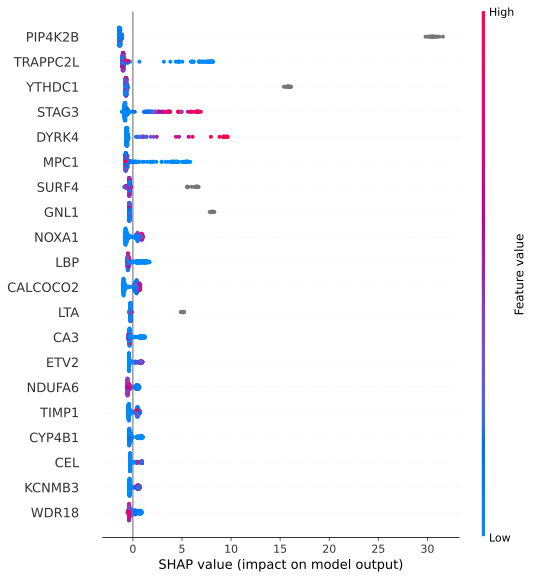

In [18]:
results1.plot(max_display=100)

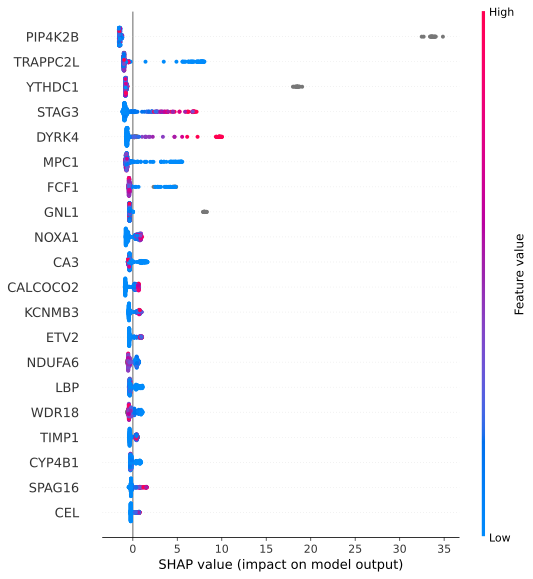

In [19]:
results2.plot(max_display=100)

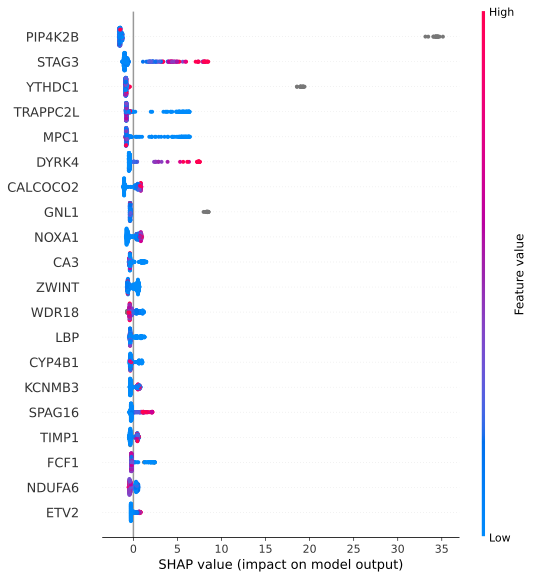

In [20]:
results3.plot(max_display=100)

## Intersections ##

In [21]:
print(results1.selected.shape[0])
print(results2.selected.shape[0])
print(results3.selected.shape[0])

41
40
34


In [22]:
print("genes same in all 3 runs")
results1.selected.index.intersection(results2.selected.index).intersection(results3.selected.index).shape[0]

genes same in all 3 runs


23

In [42]:
rs = results1.selected.loc[results1.selected.index.intersection(results2.selected.index).intersection(results3.selected.index)]
rs_sorted = rs.sort_values(by="kendall_tau_to_lifespan", ascending=False)
rs_sorted.symbol.values

array(['LRR1', 'CALCOCO2', 'NOXA1', 'ETV2', 'SPAG16', 'ADGRF3', 'TIMP1',
       'STAG3', 'LIN7B', 'DYRK4', 'LTA', 'YTHDC1', 'PIP4K2B', 'SURF4',
       'GNL1', 'TRAPPC2L', 'FCF1', 'MPC1', 'FECH', 'CA3', 'NFKBIL1',
       'CLIC3', 'DPP9'], dtype=object)

## SHAP details display ##

In [23]:
results1.selected_extended

symbol  gain_score_to_lifespan  kendall_tau_to_lifespan  \
ensembl_id                                                                   
ENSG00000276293   PIP4K2B              490397.253                    0.040   
ENSG00000083896    YTHDC1              264669.053                    0.134   
ENSG00000010219     DYRK4              174123.179                    0.317   
ENSG00000204590      GNL1              128887.868                   -0.086   
ENSG00000167515  TRAPPC2L              123163.320                   -0.157   
ENSG00000060762      MPC1              104456.703                   -0.413   
ENSG00000148248     SURF4               84788.370                   -0.059   
ENSG00000226979       LTA               72675.053                    0.220   
ENSG00000066923     STAG3               61169.472                    0.484   
ENSG00000204498   NFKBIL1               44790.616                   -0.575   
ENSG00000102265     TIMP1               29013.064                    0.529   
ENSG00000184983    NDUFA6               28564.782                   -0.538   
ENSG00000105672      ETV2               27246.032                    0.692   
ENSG00000129988       LBP               26371.047                   -0.575   
ENSG00000136436  CALCOCO2               24069.406                    0.731   
ENSG00000164879       CA3               20709.987                   -0.550   
ENSG00000188747     NOXA1               20312.518                    0.722   
ENSG00000188763      FZD9               19638.813                    0.136   
ENSG00000119616      FCF1               19383.221                   -0.339   
ENSG00000170835       CEL               17744.290                    0.643   
ENSG00000173567    ADGRF3               17091.653                    0.542   
ENSG00000144451    SPAG16               12711.536                    0.569   
ENSG00000171121    KCNMB3               10722.120                    0.631   
ENSG00000142002      DPP9                9982.817                   -0.733   
ENSG00000105993    DNAJB6                8870.524                    0.420   
ENSG00000066926      FECH                7738.474                   -0.545   
ENSG00000134489      HRH4                7727.520                    0.716   
ENSG00000065268     WDR18                7206.605                   -0.764   
ENSG00000101190     TCFL5                6771.241                    0.723   
ENSG00000103152       MPG                6279.602                    0.624   
ENSG00000122952     ZWINT                6215.905                   -0.649   
ENSG00000114405   C3orf14                6202.812                   -0.441   
ENSG00000157343    ARMC12                6117.174                    0.684   
ENSG00000089053    ANAPC5                5499.404                   -0.569   
ENSG00000165501      LRR1                3261.293                    0.763   
ENSG00000211454     AKR7L                2583.875                   -0.255   
ENSG00000169583     CLIC3                2106.483                   -0.596   
ENSG00000101928    MOSPD1                1973.089                   -0.637   
ENSG00000104863     LIN7B                1663.941                    0.349   
ENSG00000143742      SRP9                1495.254                    0.626   
ENSG00000142541    RPL13A                1247.264                   -0.180   

                 SRR1521445  SRR5008362  SRR8702484  SRR5961972  SRR5961875  \
ensembl_id                                                                    
ENSG00000276293      30.517      31.577      30.949      30.656      31.214   
ENSG00000083896      15.845      16.063      15.795      16.031      16.109   
ENSG00000010219       9.484       9.230       9.225       9.588       9.661   
ENSG00000204590       8.111       8.256       8.291       8.156       8.234   
ENSG00000167515      -0.505      -0.509      -0.475      -0.483      -0.482   
ENSG00000060762       0.045      -0.342      -0.342       0.003      -0.335   
ENSG00000148248       6.348     

## per gene ##

In [24]:
show(results1.partitions.X,10,10)

ensembl_id  ENSG00000139990  ENSG00000073921  ENSG00000139687  \
run                                                             
SRR1521445           11.921           78.535           10.850   
SRR5008362            4.765           51.601            8.809   
SRR8702484            5.864           23.870            2.812   
SRR5961972           29.373          532.382           54.231   
SRR5961875           20.683          645.336           56.189   
SRR5961830           26.655          465.005           55.082   
SRR5885325           10.578           95.720            7.969   
SRR5120940           33.205          113.369           21.872   
SRR5120939           37.904          124.517           27.603   
SRR306839            12.512          104.142            5.173   

ensembl_id  ENSG00000119977  ENSG00000242866  ENSG00000135506  \
run                                                             
SRR1521445           10.162            8.670          100.439   
SRR5008362            2.429            0.007           39.848   
SRR8702484            6.136            0.671          116.041   
SRR5961972           12.200            4.271          100.576   
SRR5961875           10.597            1.484          116.249   
SRR5961830           13.343            3.845           86.345   
SRR5885325           17.294            0.165           92.622   
SRR5120940           20.109            0.058          166.215   
SRR5120939           24.449            0.070          172.862   
SRR306839             7.631            4.599           92.039   

ensembl_id  ENSG00000162426  ENSG00000165995  ENSG00000073756  ENSG00000138050  
run                                                                             
SRR1521445           11.340           22.534            2.425           20.061  
SRR5008362            0.195            5.933            0.077           25.693  
SRR8702484            0.552            0.188            0.625            2.050  
SRR5961972            8.889          132.921           23.412           29.121  
SRR5961875            5.227           87.490            7.386           25.597  
SRR5961830            7.693          137.115           13.902           52.017  
SRR5885325            1.908            3.058            4.627            4.955  
SRR5120940            0.758            3.179           14.629            9.393  
SRR5120939            1.138            2.437           54.820           12.161  
SRR306839            20.007           29.659            2.401            3.781

In [25]:
first = results1.gene_details("YTHDC1", data.samples) 
show(first,100,10)

general info: symbol                        YTHDC1
gain_score_to_lifespan    264669.053
kendall_tau_to_lifespan        0.134
Name: ENSG00000083896, dtype: object


expressions shap_values   bioproject  \
run                                               
SRR1521445         NaN      15.845  PRJNA255754   
SRR5008362         NaN      16.063  PRJNA352990   
SRR8702484         NaN      15.795  PRJNA526249   
SRR5961972         NaN      16.031  PRJNA398031   
SRR5961875         NaN      16.109  PRJNA398031   
SRR5961830         NaN      16.046  PRJNA398031   
SRR5885325         NaN      15.721  PRJNA396588   
SRR5120940         NaN      15.869  PRJNA358081   
SRR5120939         NaN      15.866  PRJNA358081   
SRR306839          NaN      15.809  PRJNA143627   

                                              series       species  tissue  \
run                                                                          
SRR1521445            geo/query/acc.cgi?acc=GSE59612  Homo_sapiens   Brain   
SRR5008362            geo/query/acc.cgi?acc=GSE89714  Homo_sapiens   Heart   
SRR8702484                               PRJNA526249  Homo_sapiens   Liver   
SRR5961972                               PRJNA398031  Homo_sapiens   Brain   
SRR5961875                               PRJNA398031  Homo_sapiens   Brain   
SRR5961830                               PRJNA398031  Homo_sapiens   Brain   
SRR5885325  geo/query/acc.cgi?acc=GSE86095_GSE102101  Homo_sapiens  Kidney   
SRR5120940                               PRJNA358081  Homo_sapiens    Lung   
SRR5120939                               PRJNA358081  Homo_sapiens    Lung   
SRR306839             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   

           sample_name                                    characteristics  \
run                                                                         
SRR1521445  GSM1440503  non-neoplastic brain tissue;non-neoplastic bra...   
SRR5008362  GSM2387234                                     Heart;heart;no   
SRR8702484  GSM3662889                    Liver;Penn Cohort 1;liver;B7;no   
SRR5961972  GSM2740785  no;no;5.6;no;72;17;Anterior Insula (aINS);yes ...   
SRR5961875  GSM2740688  no;yes;7.5;no;55;2.5;Dorsolateral prefrontal c...   
SRR5961830  GSM2740643  no;no;5.7;no;72;17;Orbitofrontal (OFC; BA11);y...   
SRR5885325  GSM2723925  no;adjacent normal kidney;patient 40911432;adj...   
SRR5120940  GSM2433136                        lung tissue;lung;Control;no   
SRR5120939  GSM2433135                        lung tissue;lung;Control;no   
SRR306839    GSM752692  Brain, frontal cortex;male;8.8;Commercial / Am...   

                               sequencer  age     sex tumor  \
run                                                           
SRR1521445           Illumina_HiSeq_2000  NaN     NaN    no   
SRR5008362           Illumina_HiSeq_2000  NaN     NaN    no   
SRR8702484           Illumina_HiSeq_2500  NaN     NaN    no   
SRR5961972           Illumina_HiSeq_2000   72  female    no   
SRR5961875           Illumina_HiSeq_2000   55  female    no   
SRR5961830           Illumina_HiSeq_2000   72  female    no   
SRR5885325           Illumina_HiSeq_2000  NaN     NaN    no   
SRR5120940           Illumina_HiSeq_2000  NaN     NaN    no   
SRR5120939           Illumina_HiSeq_2000  NaN     NaN    no   
SRR306839   Illumina_Genome_Analyzer_IIx  NaN    male    no   

                                                   source  \
run                                                         
SRR1521445                    non-neoplastic brain tissue   
SRR5008362                                          heart   
SRR8702484                                          liver   
SRR5961972                         Anterior Insula (aINS)   
SRR5961875  Dorsolateral prefrontal cortex (dlPFC; BA8/9)   
SRR5961830                      Orbitofrontal (OFC; BA11)   
SRR5885325                         adjacent normal kidney   
SRR5120940                                           lung   
SRR5120939                                           lung   
SRR306839                           Brain, frontal cortex   

                                              

In [26]:
human = first[(first.species == "Homo_sapiens")]
#human[human.expressions.isna()==False]
human

expressions shap_values   bioproject  \
run                                               
SRR1521445         NaN      15.845  PRJNA255754   
SRR5008362         NaN      16.063  PRJNA352990   
SRR8702484         NaN      15.795  PRJNA526249   
SRR5961972         NaN      16.031  PRJNA398031   
SRR5961875         NaN      16.109  PRJNA398031   
SRR5961830         NaN      16.046  PRJNA398031   
SRR5885325         NaN      15.721  PRJNA396588   
SRR5120940         NaN      15.869  PRJNA358081   
SRR5120939         NaN      15.866  PRJNA358081   
SRR306839          NaN      15.809  PRJNA143627   
SRR306840          NaN      15.812  PRJNA143627   
SRR306841          NaN      15.855  PRJNA143627   
SRR306842          NaN      15.798  PRJNA143627   
SRR306843          NaN      15.794  PRJNA143627   
SRR306844          NaN      15.736  PRJNA143627   
SRR306845          NaN      15.752  PRJNA143627   
SRR787277          NaN      15.378  PRJNA193501   
SRR3715877         NaN      15.527  PRJNA326784   

                                              series       species  tissue  \
run                                                                          
SRR1521445            geo/query/acc.cgi?acc=GSE59612  Homo_sapiens   Brain   
SRR5008362            geo/query/acc.cgi?acc=GSE89714  Homo_sapiens   Heart   
SRR8702484                               PRJNA526249  Homo_sapiens   Liver   
SRR5961972                               PRJNA398031  Homo_sapiens   Brain   
SRR5961875                               PRJNA398031  Homo_sapiens   Brain   
SRR5961830                               PRJNA398031  Homo_sapiens   Brain   
SRR5885325  geo/query/acc.cgi?acc=GSE86095_GSE102101  Homo_sapiens  Kidney   
SRR5120940                               PRJNA358081  Homo_sapiens    Lung   
SRR5120939                               PRJNA358081  Homo_sapiens    Lung   
SRR306839             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306840             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306841             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306842             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306843             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306844             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306845             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR787277             geo/query/acc.cgi?acc=GSE45326  Homo_sapiens    Lung   
SRR3715877            geo/query/acc.cgi?acc=GSE83717  Homo_sapiens    Lung   

           sample_name                                    characteristics  \
run                                                                         
SRR1521445  GSM1440503  non-neoplastic brain tissue;non-neoplastic bra...   
SRR5008362  GSM2387234                                     Heart;heart;no   
SRR8702484  GSM3662889                    Liver;Penn Cohort 1;liver;B7;no   
SRR5961972  GSM2740785  no;no;5.6;no;72;17;Anterior Insula (aINS);yes ...   
SRR5961875  GSM2740688  no;yes;7.5;no;55;2.5;Dorsolateral prefrontal c...   
SRR5961830  GSM2740643  no;no;5.7;no;72;17;Orbitofrontal (OFC; BA11);y...   
SRR5885325  GSM2723925  no;adjacent normal kidney;patient 40911432;adj...   
SRR5120940  GSM2433136                        lung tissue;lung;Control;no   
SRR5120939  GSM2433135                        lung tissue;lung;Control;no   
SRR306839    GSM752692  Brain, frontal cortex;male;8.8;Commercial / Am...   
SRR306840    GSM752693  Brain, prefrontal cortex;male;8.6;Netherland B...   
SRR306841    GSM752694  Brain, prefrontal cortex;male;8.5;Netherland B...   
SRR306842    GSM752695  Brain, prefrontal cortex;male;7.8;Netherland B...   
SRR306843    GSM752696  Brain, temporal lobe;male;8.1;Commercial / AMS...   
SRR306844    GSM752697  Cerebellum;female;8.5;Commercial / AMS biotech...   
SRR306845    GSM752698         Cerebellum;male;8.9;Commercial / Ambion;no   
SRR787277   GSM1101973                     